# Supervised Learning Capstone: Predicting Wins for League of Legends

In this model, we will be using several different classifiers to predict wins for League of Legends.  Here's the original [link](https://www.kaggle.com/datasnaek/league-of-legends#games.csv) for this dataset.  

The game consists of two teams with 5 players each.  Through a coordinated team effort & skill, each team tries to win by destroying the other team's nexus.  Before the game, each player gets to choose a champion to play.  In addition, they get to choose two summoner spells (order of spells doesn't effect gameplay). And finally, each team gets to ban 5 champions.  Banned champions won't be able to be used by either team.  After these decisions are made, the game starts.

Our goal is to predict the winner of each match using the following: champion choices, ban choices, & summoner spell choices.  Although kill counts & game duration are included in this dataset, we will NOT be using these metrics.  We want to see if we can predict the winner before the game starts.  Because of this, we will not use metrics that accrue after the game starts.  

Our model would be useless if we need to watch an entire match to determine the winner.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import json

from scipy.stats import boxcox
from scipy.stats import zscore
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats.mstats import winsorize

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

sb_pal = "Blues_r"

# Loading data

The variables gameID and creationTime are just identification markers.  Since all of these entries are from season 9, we will remove seasonId.  

In [2]:
# link to load dataset
path = "C:\\Users\\James\\Desktop\\Data_Folder\\LOL\\games.csv"

# list of unnecessary columns
droplist = ['gameId', 
            'creationTime', 
            'seasonId', 
            'firstBlood', 
            'firstTower', 
            'firstInhibitor', 
            'firstBaron', 
            'firstDragon', 
            'firstRiftHerald',
            't1_towerKills', 
            't1_inhibitorKills', 
            't1_baronKills', 
            't1_dragonKills', 
            't1_riftHeraldKills', 
            't2_towerKills', 
            't2_inhibitorKills', 
            't2_baronKills', 
            't2_dragonKills', 
            't2_riftHeraldKills'
           ]

## Loading champion info

In [3]:
# load codes for each category which returns a dictionary of dictionaries

json_link = "C:\\Users\\James\\Desktop\\Data_Folder\\LOL\\champion_info_2.json"

json1_file = open(json_link, 'r')
json1_str = json1_file.read()

# we want all the info in the 'data' key of this dictionary
champ_full = json.loads(json1_str)['data']

# they use a separate id for champ as the key
champ_full['MonkeyKing']

{'tags': ['Fighter', 'Tank'],
 'title': 'the Monkey King',
 'id': 62,
 'key': 'MonkeyKing',
 'name': 'Wukong'}

The data is weirdly formatted.  We will need to create a simple dictionary that links the champ id with the name.

In [4]:
champ_names = {}
for item in champ_full.keys():
    champ_id = champ_full[item]['id']
    champ_names[champ_id] = champ_full[item]['name']

champ_names

{-1: 'None',
 62: 'Wukong',
 24: 'Jax',
 9: 'Fiddlesticks',
 35: 'Shaco',
 19: 'Warwick',
 498: 'Xayah',
 76: 'Nidalee',
 143: 'Zyra',
 240: 'Kled',
 63: 'Brand',
 33: 'Rammus',
 420: 'Illaoi',
 42: 'Corki',
 201: 'Braum',
 122: 'Darius',
 23: 'Tryndamere',
 21: 'Miss Fortune',
 83: 'Yorick',
 101: 'Xerath',
 15: 'Sivir',
 92: 'Riven',
 61: 'Orianna',
 41: 'Gangplank',
 54: 'Malphite',
 78: 'Poppy',
 30: 'Karthus',
 126: 'Jayce',
 20: 'Nunu',
 48: 'Trundle',
 104: 'Graves',
 25: 'Morgana',
 150: 'Gnar',
 99: 'Lux',
 102: 'Shyvana',
 58: 'Renekton',
 114: 'Fiora',
 222: 'Jinx',
 429: 'Kalista',
 105: 'Fizz',
 38: 'Kassadin',
 37: 'Sona',
 39: 'Irelia',
 112: 'Viktor',
 497: 'Rakan',
 203: 'Kindred',
 69: 'Cassiopeia',
 57: 'Maokai',
 516: 'Ornn',
 412: 'Thresh',
 10: 'Kayle',
 120: 'Hecarim',
 121: "Kha'Zix",
 2: 'Olaf',
 115: 'Ziggs',
 134: 'Syndra',
 36: 'Dr. Mundo',
 43: 'Karma',
 1: 'Annie',
 84: 'Akali',
 106: 'Volibear',
 157: 'Yasuo',
 85: 'Kennen',
 107: 'Rengar',
 13: 'Ryze',
 

## Loading summoner spell info

In [5]:
# load codes for each category which returns a dictionary of dictionaries

json_link2 = "C:\\Users\\James\\Desktop\\Data_Folder\\LOL\\summoner_spell_info.json"

json2_file = open(json_link2, 'r')
json2_str = json2_file.read()

# we want all the info in the 'data' key of this dictionary
sum_full = json.loads(json2_str)['data']

# show a sample
sum_full['1']

{'id': 1,
 'summonerLevel': 6,
 'name': 'Cleanse',
 'key': 'SummonerBoost',
 'description': 'Removes all disables (excluding suppression and airborne) and summoner spell debuffs affecting your champion and lowers the duration of incoming disables by 65% for 3 seconds.'}

We will need to create a simple dictionary that links the summoner spell id with the name.

In [6]:
sum_names = {}
for item in sum_full.keys():
    sum_names[int(item)] = sum_full[item]['name']

sum_names

{1: 'Cleanse',
 3: 'Exhaust',
 4: 'Flash',
 6: 'Ghost',
 7: 'Heal',
 11: 'Smite',
 12: 'Teleport',
 13: 'Clarity',
 14: 'Ignite',
 21: 'Barrier',
 30: 'To the King!',
 31: 'Poro Toss',
 32: 'Mark',
 33: 'Nexus Siege: Siege Weapon Slot',
 34: 'Nexus Siege: Siege Weapon Slot',
 35: 'Disabled Summoner Spells',
 36: 'Disabled Summoner Spells'}

# Step 1: Exploratory data analysis

In [7]:
# load and remove columns
df = pd.read_csv(path)
df.drop(columns=droplist, inplace=True)

df.head()

,gameDuration,winner,t1_champ1id,t1_champ1_sum1,t1_champ1_sum2,t1_champ2id,t1_champ2_sum1,t1_champ2_sum2,t1_champ3id,t1_champ3_sum1,...,t2_champ4_sum1,t2_champ4_sum2,t2_champ5id,t2_champ5_sum1,t2_champ5_sum2,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,1949,1,8,12,4,432,3,4,96,4,...,14,4,412,4,3,114,67,43,16,51
1,1851,1,119,7,4,39,12,4,76,4,...,4,14,92,4,7,11,67,238,51,420
2,1493,1,18,4,7,141,11,4,267,3,...,4,11,22,7,4,157,238,121,57,28
3,1758,1,57,4,12,63,4,14,29,4,...,4,14,22,4,7,164,18,141,40,51
4,2094,1,19,4,12,29,11,4,40,4,...,4,12,51,4,7,86,11,201,122,18


Winner is the team number (1 or 2).  All champions, summoner spells, & bans are id numbers.  The json files we loaded earlier have dictionaries to convert those numbers into actual names.

In [8]:
df.columns

Index(['gameDuration', 'winner', 't1_champ1id', 't1_champ1_sum1',
       't1_champ1_sum2', 't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2',
       't1_champ3id', 't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1',
       't1_champ5_sum2', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4', 't1_ban5',
       't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2', 't2_champ2id',
       't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id', 't2_champ3_sum1',
       't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1', 't2_champ4_sum2',
       't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2', 't2_ban1', 't2_ban2',
       't2_ban3', 't2_ban4', 't2_ban5'],
      dtype='object')

## Analyzing Wins (Target Variable)

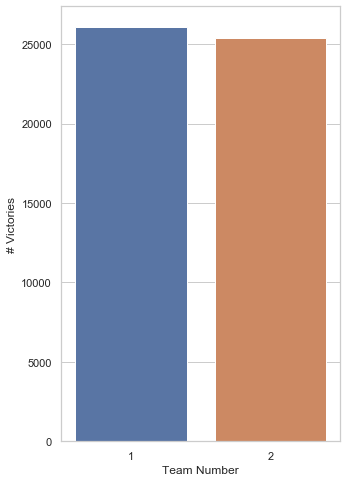

In [9]:
plt.figure(figsize=(5,8))
sns.countplot(x="winner", data=df)
plt.xlabel('Team Number')
plt.ylabel('# Victories');

Overall, we can see that the distribution is well balanced.  There is a slight difference in favor of team 1, but it may not be statistically significant.

## Analyzing Summoner Spells

Define the summoner spell columns.

In [10]:
# define plot columns
plot_col1 = ['t1_champ1_sum1',
             't1_champ2_sum1',
             't1_champ3_sum1', 
             't1_champ4_sum1',
             't1_champ5_sum1'
            ]

plot_col2 = ['t1_champ1_sum2',
             't1_champ2_sum2',
             't1_champ3_sum2', 
             't1_champ4_sum2',
             't1_champ5_sum2'
            ]

plot_col3 = ['t2_champ1_sum1',
             't2_champ2_sum1',
             't2_champ3_sum1', 
             't2_champ4_sum1',
             't2_champ5_sum1'
            ]

plot_col4 = ['t2_champ1_sum2',
             't2_champ2_sum2',
             't2_champ3_sum2', 
             't2_champ4_sum2',
             't2_champ5_sum2'
            ]

# let's melt the dataframe for each team
t1_sum1 = pd.melt(df[plot_col1])
t1_sum2 = pd.melt(df[plot_col2])
t1_sum3 = pd.melt(df[plot_col3])
t1_sum4 = pd.melt(df[plot_col4])

# here's a sample
t1_sum1.head()

,variable,value
0,t1_champ1_sum1,12
1,t1_champ1_sum1,7
2,t1_champ1_sum1,4
3,t1_champ1_sum1,4
4,t1_champ1_sum1,4


The original dataframe defines the summoner spell choice as its id number.  We will have to convert the id number to it's corresponding spell.  Note that the values used (and the order of the values) are the same regardless of team or which spell slot is used (1st or 2nd).

In [11]:
# get unique values in champ list
sum_labels = list(df.t1_champ1_sum1.sort_values().unique())

# convert the values based on dictionary
sum_labels = [sum_names[i] for i in sum_labels]

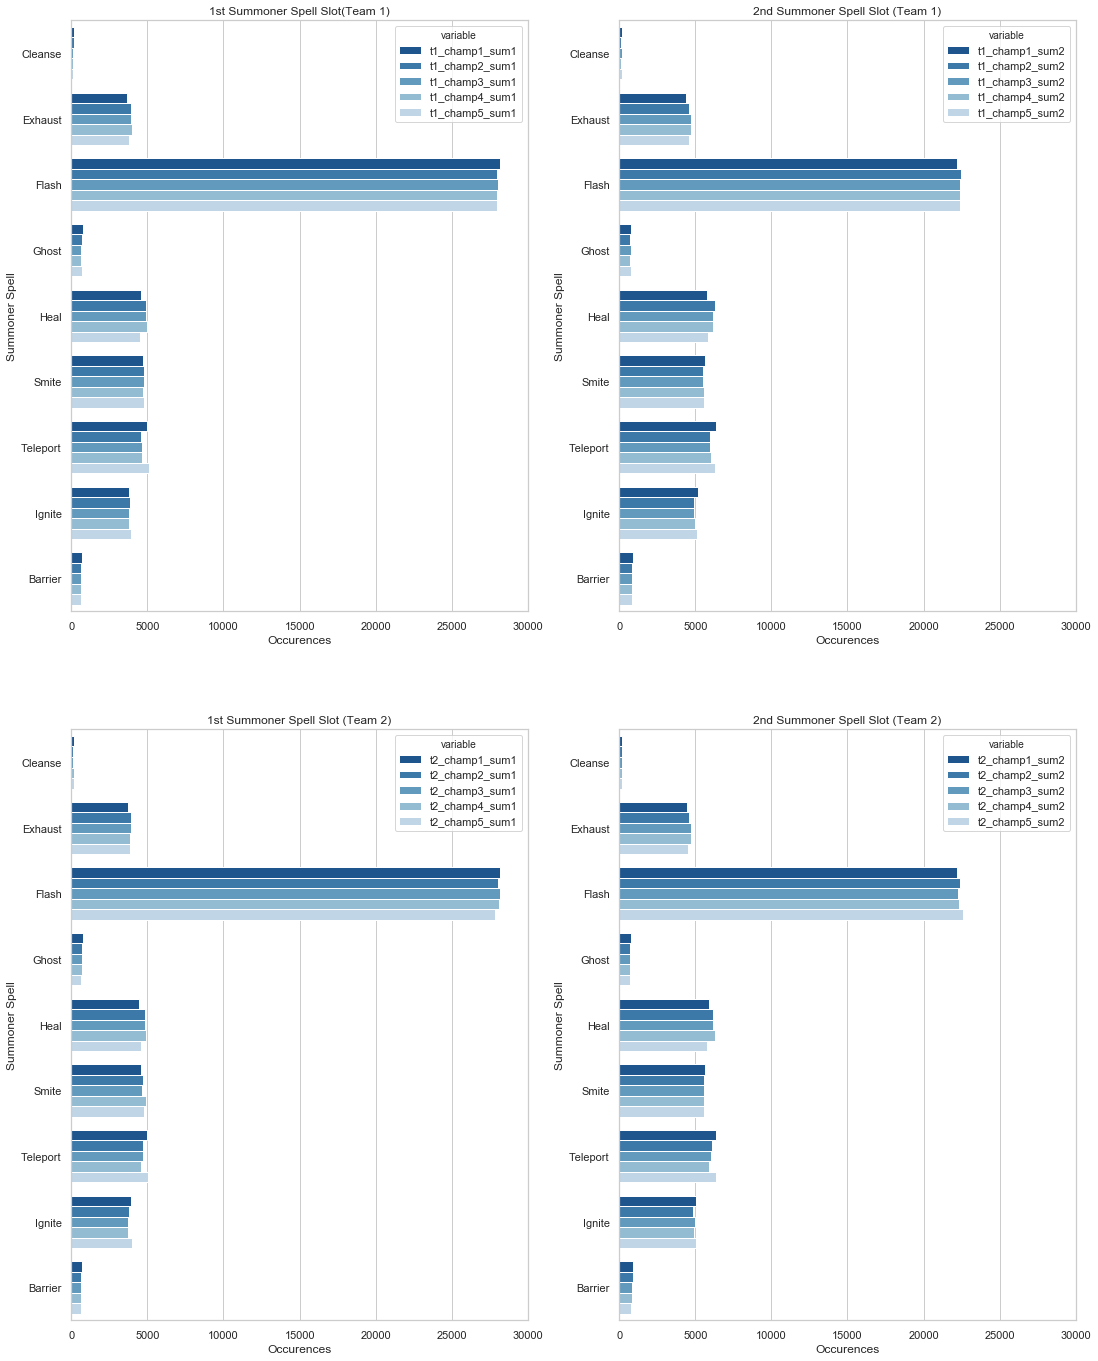

In [12]:
# plot the data
plt.figure(figsize=(18,50))

ax = plt.subplot(4, 2, 1)
sns.countplot(y="value", hue="variable", data=t1_sum1, palette=sns.color_palette(sb_pal))
plt.title('1st Summoner Spell Slot(Team 1)')
plt.xlabel('Occurences')
plt.ylabel('Summoner Spell')
plt.xlim(0, 30000)
ax.set_yticklabels(labels=sum_labels)

ax = plt.subplot(4, 2, 2)
sns.countplot(y="value", hue="variable", data=t1_sum2, palette=sns.color_palette(sb_pal))
plt.title('2nd Summoner Spell Slot (Team 1)')
plt.xlabel('Occurences')
plt.ylabel('Summoner Spell')
plt.xlim(0, 30000)
ax.set_yticklabels(labels=sum_labels)

ax = plt.subplot(4, 2, 3)
sns.countplot(y="value", hue="variable", data=t1_sum3, palette=sns.color_palette(sb_pal))
plt.title('1st Summoner Spell Slot (Team 2)')
plt.xlabel('Occurences')
plt.ylabel('Summoner Spell')
plt.xlim(0, 30000)
ax.set_yticklabels(labels=sum_labels)

ax = plt.subplot(4, 2, 4)
sns.countplot(y="value", hue="variable", data=t1_sum4, palette=sns.color_palette(sb_pal))
plt.title('2nd Summoner Spell Slot (Team 2)')
plt.xlabel('Occurences')
plt.ylabel('Summoner Spell')
plt.xlim(0, 30000)
ax.set_yticklabels(labels=sum_labels);

Overall, we see that the distribution of team spells is generally the same regardless of which spell slot is used (comparing 1st or 2nd slots).  The distribution is also the same regardless of which champion (champ1 to champ5) is running the spell. 

This should make intuitive sense as there is no benefit to champ position (champ1 to champ5) or spell slot location (1st/2nd).  It comes down to player preference. In addition, we can see that Flash is a very popular choice for one the spell slots.  It may be possible that failing to choose Flash may affect the chances of winning.

## Analyzing Champion Choice

In [13]:
# define plot columns

plot_col1 = ['t1_champ1id', 
             't1_champ2id', 
             't1_champ3id', 
             't1_champ4id',
             't1_champ5id'
            ]

plot_col2 = ['t2_champ1id', 
             't2_champ2id', 
             't2_champ3id', 
             't2_champ4id',
             't2_champ5id'
            ]

# let's melt the dataframe for each team
t1_champ = pd.melt(df[plot_col1])
t2_champ = pd.melt(df[plot_col2])

# here's a sample
t1_champ.head()

,variable,value
0,t1_champ1id,8
1,t1_champ1id,119
2,t1_champ1id,18
3,t1_champ1id,57
4,t1_champ1id,19


In [14]:
# there are way too many champions to show, so we will only look at top 10
top_t1 = t1_champ['value'].value_counts().iloc[:10].index
top_t2 = t2_champ['value'].value_counts().iloc[:10].index

# convert the values based on dictionary
t1_champ_labels = [champ_names[i] for i in top_t1]
t2_champ_labels = [champ_names[i] for i in top_t2]

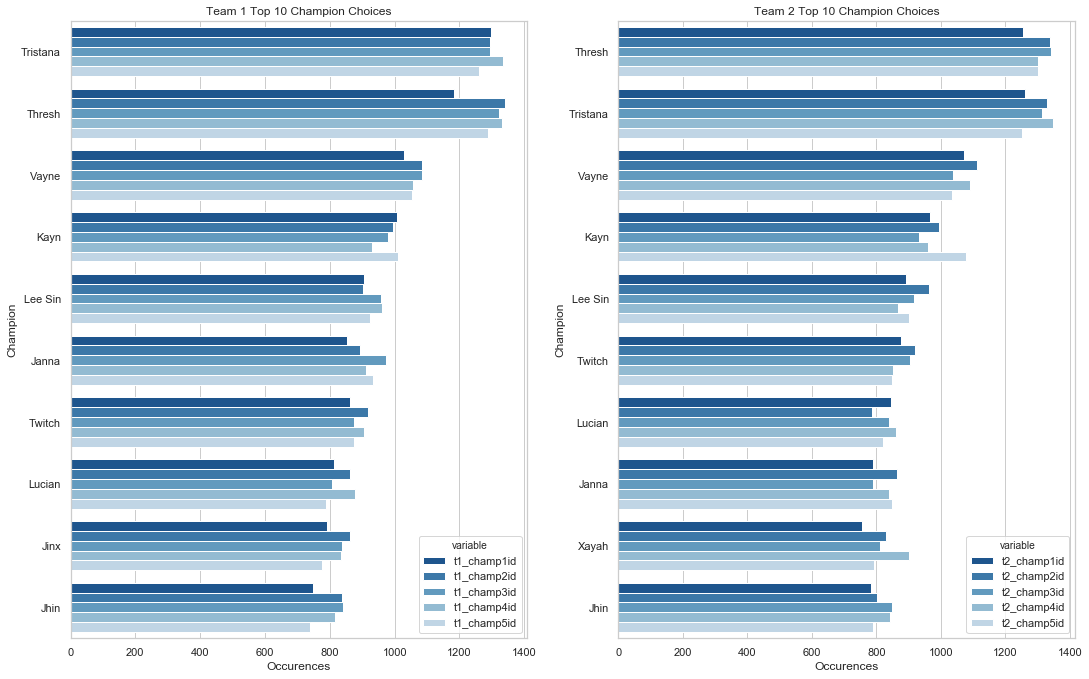

In [15]:
plt.figure(figsize=(18,25))

ax = plt.subplot(2, 2, 1)
sns.countplot(y="value", hue="variable", data=t1_champ, order=top_t1, palette=sns.color_palette(sb_pal))
plt.title('Team 1 Top 10 Champion Choices')
plt.xlabel('Occurences')
plt.ylabel('Champion')
ax.set_yticklabels(labels=t1_champ_labels)

ax = plt.subplot(2, 2, 2)
sns.countplot(y="value", hue="variable", data=t2_champ, order=top_t2, palette=sns.color_palette(sb_pal))
plt.title('Team 2 Top 10 Champion Choices')
plt.xlabel('Occurences')
plt.ylabel('Champion')
ax.set_yticklabels(labels=t2_champ_labels);

Not surprisely, we see a relative balance of champ choice between teams 1 & 2.  Let's see a complete distribution for one of the teams.

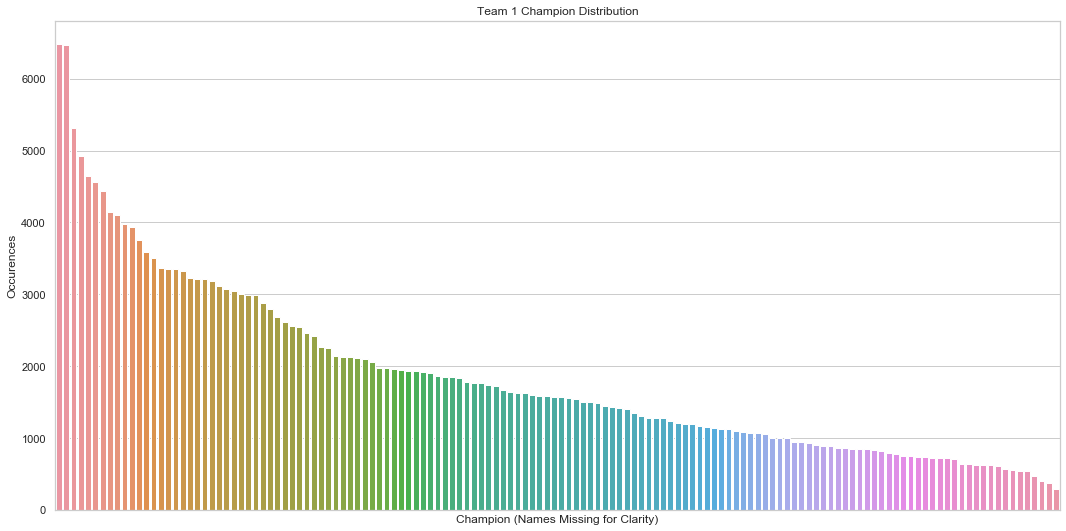

In [16]:
plt.figure(figsize=(18,9))
sns.countplot(x="value", data=t1_champ, order=t1_champ['value'].value_counts().index)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.title('Team 1 Champion Distribution')
plt.ylabel('Occurences')
plt.xlabel('Champion (Names Missing for Clarity)');

Overall, we see that there are vast differences in champion choice when we compare entire champion list as a whole.  Is it possible that choosing an unpopular champion will play a part in chances of winning?  We will see when we create our model.    

## Analyzing Champion Ban Choice

Let's analyze champion bans the same way we analyzed the champion choices.

In [17]:
# define plot columns

plot_col1 = ['t1_ban1', 
             't1_ban2', 
             't1_ban3', 
             't1_ban4', 
             't1_ban5'
            ]

plot_col2 = ['t2_ban1', 
             't2_ban2', 
             't2_ban3', 
             't2_ban4', 
             't2_ban5'
            ]

# let's melt the dataframe for each team
t1_champ = pd.melt(df[plot_col1])
t2_champ = pd.melt(df[plot_col2])

# here's a sample
t1_champ.head()

# there are way too many champions to show, so we will only look at top 10
top_t1 = t1_champ['value'].value_counts().iloc[:10].index
top_t2 = t2_champ['value'].value_counts().iloc[:10].index

# convert the values based on dictionary
t1_champ_labels = [champ_names[i] for i in top_t1]
t2_champ_labels = [champ_names[i] for i in top_t2]

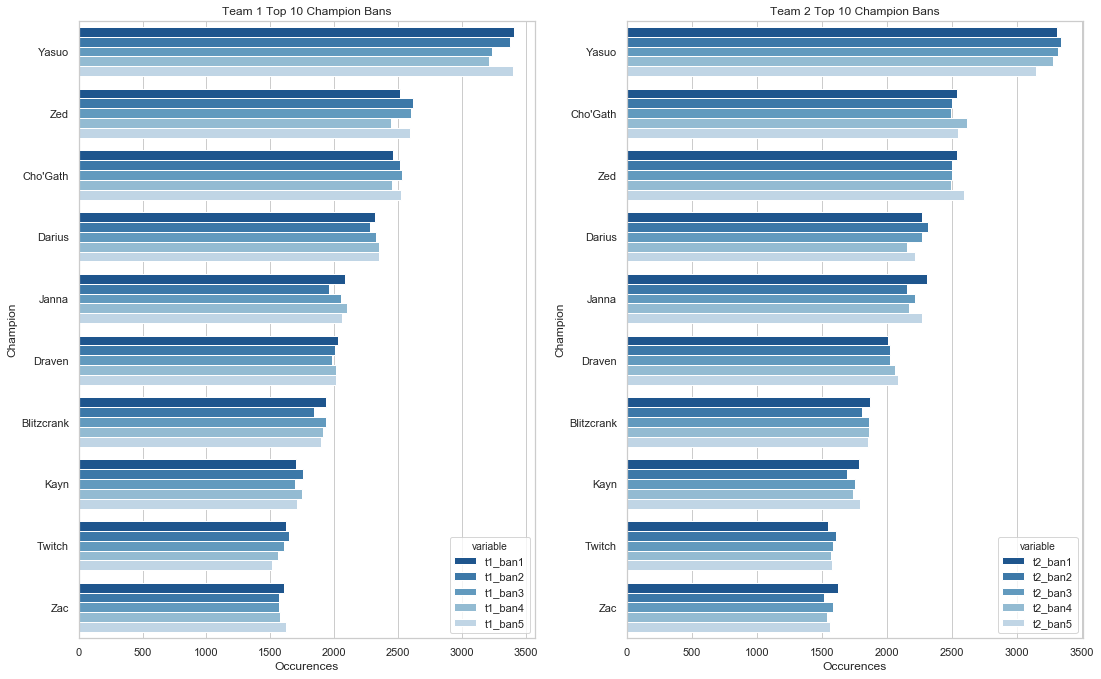

In [18]:
plt.figure(figsize=(18,25))

ax = plt.subplot(2, 2, 1)
sns.countplot(y="value", hue="variable", data=t1_champ, order=top_t1, palette=sns.color_palette(sb_pal))
plt.title('Team 1 Top 10 Champion Bans')
plt.xlabel('Occurences')
plt.ylabel('Champion')
ax.set_yticklabels(labels=t1_champ_labels)

ax = plt.subplot(2, 2, 2)
sns.countplot(y="value", hue="variable", data=t2_champ, order=top_t2, palette=sns.color_palette(sb_pal))
plt.title('Team 2 Top 10 Champion Bans')
plt.xlabel('Occurences')
plt.ylabel('Champion')
ax.set_yticklabels(labels=t2_champ_labels);

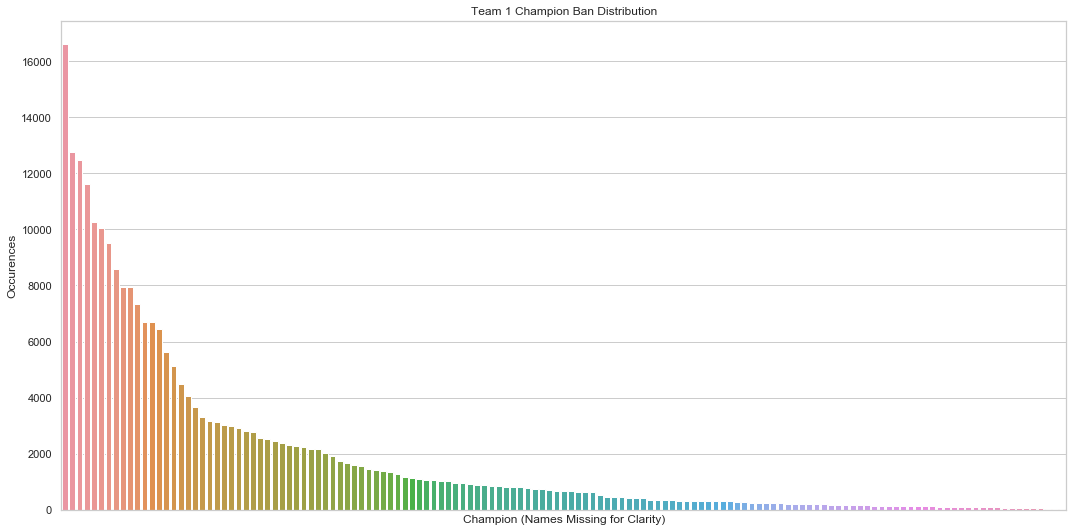

In [19]:
plt.figure(figsize=(18,9))
sns.countplot(x="value", data=t1_champ, order=t1_champ['value'].value_counts().index)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
plt.title('Team 1 Champion Ban Distribution')
plt.ylabel('Occurences')
plt.xlabel('Champion (Names Missing for Clarity)');

Not surprisely, we see a relative balance of champ bans when comparing teams 1 & 2. Overall, we see that there are vast differences in champion bans when we compare entire champion list as a whole.  Is it possible that failing to ban a certain champion will play a part in chances of winning?  We will see when we create our model.   

## Analyzing Game Duration

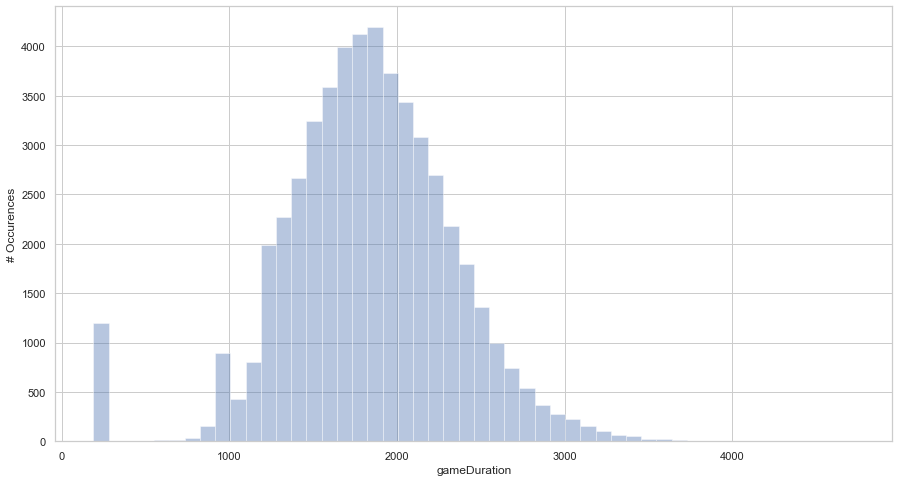

In [20]:
# let's make histograms game duration
plt.figure(figsize=(15,8))

sns.distplot(df['gameDuration' ], kde=False)
plt.ylabel('# Occurences');

We notice in game duration that there are spike in games with a very short duration (less than 10 min in).  This can be due to rage quitting.  Sometimes during a game, one or two players may disconnect prematurely from a game.  This can be due to external factors.  This results in the game being unbalanced in favor of the team with more players.  If difference in players is too high, all the players in a team will vote to quit the match early.   

For this analysis, we want to only look at games where teams win through skill and teamwork.  Games ended due to rage-quitting are not useful for this model.  I also want to note that this model should only used to predict games that are played for more than 10 minutes.  This is why we will remove these rows before we perform our test-train split.

In [21]:
# let's drop all games that last for less than two minutes
df = df[df.gameDuration > 60*10]

# we don't need game duration anymore
df.drop('gameDuration', axis=1, inplace=True)

## Null Check

There are no null values in this dataset.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50286 entries, 0 to 51489
Data columns (total 41 columns):
winner            50286 non-null int64
t1_champ1id       50286 non-null int64
t1_champ1_sum1    50286 non-null int64
t1_champ1_sum2    50286 non-null int64
t1_champ2id       50286 non-null int64
t1_champ2_sum1    50286 non-null int64
t1_champ2_sum2    50286 non-null int64
t1_champ3id       50286 non-null int64
t1_champ3_sum1    50286 non-null int64
t1_champ3_sum2    50286 non-null int64
t1_champ4id       50286 non-null int64
t1_champ4_sum1    50286 non-null int64
t1_champ4_sum2    50286 non-null int64
t1_champ5id       50286 non-null int64
t1_champ5_sum1    50286 non-null int64
t1_champ5_sum2    50286 non-null int64
t1_ban1           50286 non-null int64
t1_ban2           50286 non-null int64
t1_ban3           50286 non-null int64
t1_ban4           50286 non-null int64
t1_ban5           50286 non-null int64
t2_champ1id       50286 non-null int64
t2_champ1_sum1    50286 non-null 

# Step 2: Preparing Data

## Test-Train Split

Let's do a 20/80 test-train split.  We plan to run all our cross-validations within the train set.  When we finalize our model, we will use the test set to see how accurate it is.

In [23]:
X = df.drop('winner', axis=1)
y = df.winner

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=1337)

## Preparing data for ROC curves

We will also be plotting ROC curves for all the models, so we should make new variables that binarize the 'winner' column.

In [24]:
# make all the 1s & 2s into 0s & 1s
y_train_bi = [x-1 for x in y_train]

# make all the 1s & 2s into 0s & 1s
y_test_bi = [x-1 for x in y_test]

# Step 3: Model Selection

The four models that we are going to use are random forest classifier, decision tree classifier, support vector classifier, & KNN classifier.  We will run all four models then summarize the results to determine which model will be best to fine-tune. 

The function below will keep all the relevant results in one dictionary. 

In [25]:
def model_metrics(model, X, y):
    model_sum = {}
    
    # get cross validation score & mean of CV score
    cv_score = cross_val_score(model, X, y, cv=10, n_jobs=-1)
    
    model_sum['cv_scores'] = list(cv_score)
    model_sum['cv_mean'] = np.mean(cv_score)
    
    # get confusion matrix metrics
    y_pred = model.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    model_sum['true negatives'] = tn
    model_sum['false positives'] = fp
    model_sum['false negatives'] = fn
    model_sum['true positives'] = tp
    model_sum['accuracy'] = (tp+tn)/len(y_pred)
    model_sum['f1 score'] = f1_score(y, y_pred)
    model_sum['class_report'] = classification_report(y, y_pred)
    
    return model_sum

The function below gives a clean format for all the metrics we want to see.

In [26]:
def format_metrics(model_sum):
    # print cross-validation scores
    print("Cross Validation Scores\n" + 23*"=" + "\n{}\n".format(model_sum['cv_scores']))
    print("Average CV = {}\n".format(model_sum['cv_mean']))
    
    # print classification report
    print("Classification Report\n" + 21*"=" + "\n" + model_sum['class_report'])
    
    # print confusion matrix results
    print("Confusion Matrix\n" + 16*"=" + '\nTrue Positives = {}\nTrue Negatives'\
          '= {}\nTrue Negatives = {}\nTrue Negatives = {}'\
          .format(model_sum['true positives'], 
                  model_sum['true negatives'], 
                  model_sum['false positives'], 
                  model_sum['false negatives']))

## Model 1: Random Forest Model

This is a general go-to model for classification and regression.  Since we aren't trying to predict anything beyond the target variable's range (winning and losing), we should be ok to use this.  For this RFC, we will allow bootstrap samples to allow more randomizing on our model.  Also, we will give the model max depth & max number of features to avoid overfitting.  Let's increase the number of estimators to improve accuracy.

In [27]:
# set parameters
params = {
    'max_depth': 4, 
    'n_estimators': 400,
    'max_features': 'sqrt',
    'bootstrap': True, 
}

In [28]:
# run our model
rfc = RandomForestClassifier(**params)
rfc.fit(X_train, y_train)

rfc_results = model_metrics(rfc, X_train, y_train)

In [29]:
# print metrics
format_metrics(rfc_results)

Cross Validation Scores
[0.5176441351888668, 0.5168986083499006, 0.5262242107879692, 0.5142928163062391, 0.5316927665920954, 0.5140442455878698, 0.5233714569865738, 0.5169070114370959, 0.5236200895077076, 0.5228741919443063]

Average CV = 0.5207569532688624

Classification Report
              precision    recall  f1-score   support

           1       0.54      0.77      0.63     20296
           2       0.59      0.34      0.43     19932

    accuracy                           0.55     40228
   macro avg       0.56      0.55      0.53     40228
weighted avg       0.56      0.55      0.53     40228

Confusion Matrix
True Positives = 6708
True Negatives= 15570
True Negatives = 4726
True Negatives = 13224


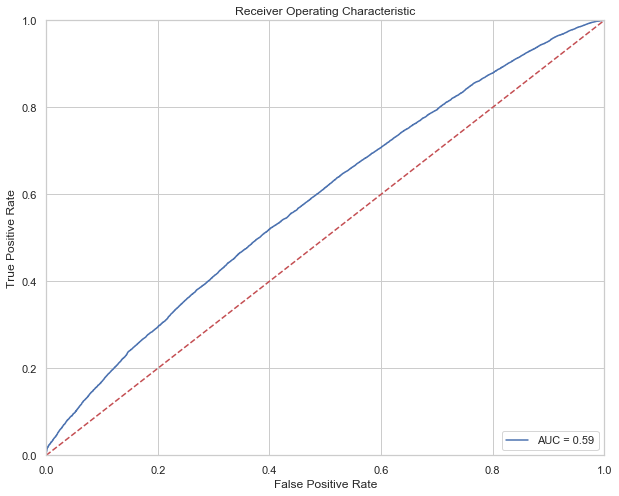

In [30]:
# print ROC curve
preds = rfc.predict_proba(X_train)[:,1]

fpr_rfc, tpr_rfc, threshold = roc_curve(y_train_bi, preds)
rfc_roc_auc = auc(fpr_rfc, tpr_rfc)
    
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rfc, tpr_rfc, 'b', label = 'AUC = %0.2f' % rfc_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##  Model 2: Decision Tree Model

If the Decision Tree cross-validation is very close to that of the RFC, we may choose this over RFC.  Decision tree is a faster model compared to RFC but loses out on accuracy.  For this decision tree, set max_depth and max number features to avoid overfitting.  Let's also set the splitter at random as well.

In [31]:
# set parameters
params = {
    'max_depth': 4, 
    'max_features': 'sqrt', 
    'splitter': 'random',
    'random_state': 1337
}

In [32]:
# run our model
dtc = tree.DecisionTreeClassifier(**params)
dtc.fit(X_train, y_train)

dtc_results = model_metrics(dtc, X_train, y_train)

In [33]:
# print metrics
format_metrics(dtc_results)

Cross Validation Scores
[0.518141153081511, 0.518141153081511, 0.5177728063634104, 0.5157842406164553, 0.49714143673875216, 0.5244842157593835, 0.5129288910989558, 0.5091994032819492, 0.49801093983092987, 0.5027349577324715]

Average CV = 0.511433919758533

Classification Report
              precision    recall  f1-score   support

           1       0.52      0.67      0.58     20296
           2       0.52      0.36      0.43     19932

    accuracy                           0.52     40228
   macro avg       0.52      0.52      0.50     40228
weighted avg       0.52      0.52      0.51     40228

Confusion Matrix
True Positives = 7242
True Negatives= 13549
True Negatives = 6747
True Negatives = 12690


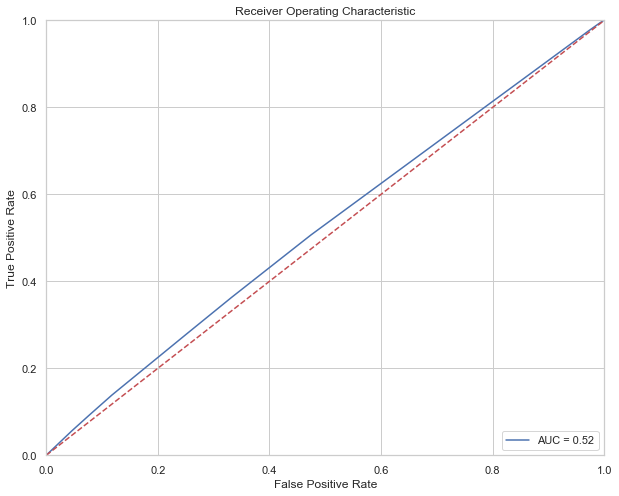

In [34]:
# print ROC curve
preds = dtc.predict_proba(X_train)[:,1]

fpr_dtc, tpr_dtc, threshold = roc_curve(y_train_bi, preds)
dtc_roc_auc = auc(fpr_dtc, tpr_dtc)
    
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_dtc, tpr_dtc, 'b', label = 'AUC = %0.2f' % dtc_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##  Model 3: Support Vector Classification Model

SVC is a powerful model with great accuracy, but is very taxing when it comes to computational efficiency.  We will use rbf to take advantage of the kernel trick.  We also want cap the iterations to improve perfromance.  We will set probability to true, so that we can use it for the ROC curve later.

For SVC, we will first have to check if there's high multicollinearity between features.  We created a table showing only pairs of features with a correlation above a certain threshold.  Based on the table below, we can see that the features aren't highly correlated with each other (greater than 0.7 correlation).

In [35]:
# define correlation threshold
corr_thresh = 0.4

# create the correlation of all features
corr = abs(df.loc[:, df.columns != 'winner'].corr())

# exclude the diagonals to avoid double counting
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(np.bool))

# stack the values
corr_triu = corr_triu.stack()

# create dataframe to show results
corr_triu.name = 'Pearson Correlation Coefficient'
corr_triu.index.names = ['Col1', 'Col2']

corr_triu[corr_triu > corr_thresh].to_frame() 

,,Pearson Correlation Coefficient
Col1,Col2,
t1_champ1_sum1,t1_champ1_sum2,0.463599
t1_champ2_sum1,t1_champ2_sum2,0.451831
t1_champ3_sum1,t1_champ3_sum2,0.443798
t1_champ4_sum1,t1_champ4_sum2,0.445397
t1_champ5_sum1,t1_champ5_sum2,0.459908
t2_champ1_sum1,t2_champ1_sum2,0.458505
t2_champ2_sum1,t2_champ2_sum2,0.451604
t2_champ3_sum1,t2_champ3_sum2,0.446320
t2_champ4_sum1,t2_champ4_sum2,0.446775


Let's also standardize/normalize the data for SVC.

In [36]:
X_train_std = StandardScaler().fit_transform(X_train)
X_train_norm = normalize(X_train_std)

In [37]:
# set parameters
params = {
    'C': 1, 
    'kernel': 'rbf', 
    'tol': 0.1, 
    'max_iter': 500, 
    'probability': True
}

In [38]:
svc = SVC(**params) 
svc.fit(X_train_norm, y_train)

svc_results = model_metrics(svc, X_train_norm, y_train)

In [39]:
# print metrics
format_metrics(svc_results)

Cross Validation Scores
[0.49502982107355864, 0.5114314115308151, 0.4978871488938603, 0.5006214267959235, 0.5033557046979866, 0.49589858314690527, 0.5131775236200895, 0.5052212829438091, 0.5072103431128792, 0.5009945300845351]

Average CV = 0.5030827775900363

Classification Report
              precision    recall  f1-score   support

           1       0.51      0.46      0.49     20296
           2       0.50      0.55      0.52     19932

    accuracy                           0.51     40228
   macro avg       0.51      0.51      0.50     40228
weighted avg       0.51      0.51      0.50     40228

Confusion Matrix
True Positives = 10950
True Negatives= 9379
True Negatives = 10917
True Negatives = 8982


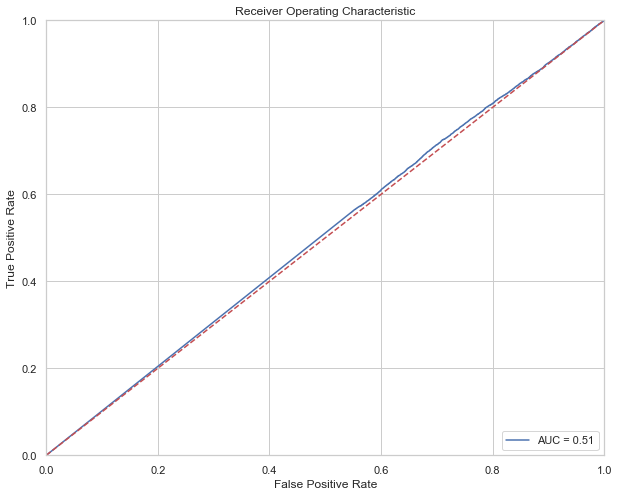

In [40]:
# print ROC curve
preds = svc.predict_proba(X_train_norm)[:,1]

fpr_svc, tpr_svc, threshold = roc_curve(y_train_bi, preds)
svc_roc_auc = auc(fpr_svc, tpr_svc)
    
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_svc, tpr_svc, 'b', label = 'AUC = %0.2f' % svc_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##  Model 4: KNN Classification Model

KNN classifiers do not make any assumptions about the data & have fairly high accuracy (but are prone to overfitting).  However, they are computationally expensive.  This is especially the case for this dataset as it has a large number of entries.  We will reduce the n_neighbors to improve performance and reduce overfitting.

In [41]:
params = {
    'n_neighbors': 3, 
    'weights': 'uniform'
}

In [42]:
knn = KNeighborsClassifier(**params) 
knn.fit(X_train, y_train)

knn_results = model_metrics(knn, X_train, y_train)

In [43]:
format_metrics(knn_results)

Cross Validation Scores
[0.4952783300198807, 0.5057157057654076, 0.5026099925428784, 0.4998757146408153, 0.5006214267959235, 0.5043499875714641, 0.5049726504226753, 0.5074589756340129, 0.49428145201392343, 0.4893088015912481]

Average CV = 0.5004473036998228

Classification Report
              precision    recall  f1-score   support

           1       0.75      0.76      0.76     20296
           2       0.75      0.75      0.75     19932

    accuracy                           0.75     40228
   macro avg       0.75      0.75      0.75     40228
weighted avg       0.75      0.75      0.75     40228

Confusion Matrix
True Positives = 14938
True Negatives= 15387
True Negatives = 4909
True Negatives = 4994


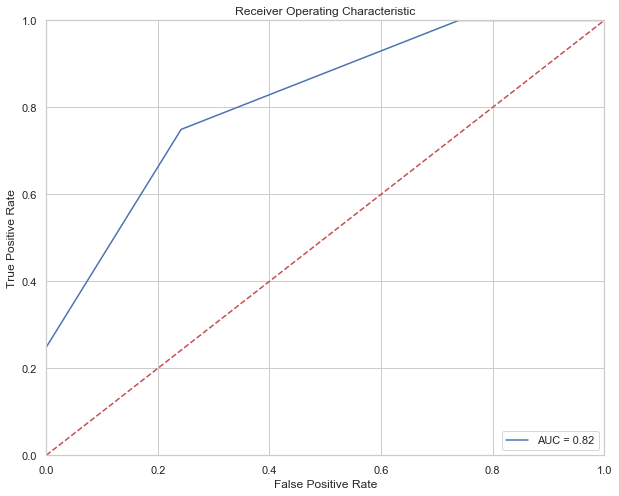

In [44]:
# print ROC curve
preds = knn.predict_proba(X_train)[:,1]

fpr_knn, tpr_knn, threshold = roc_curve(y_train_bi, preds)
knn_roc_auc = auc(fpr_knn, tpr_knn)
    
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_knn, tpr_knn, 'b', label = 'AUC = %0.2f' % knn_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Summary of Model Results

First let's create a table that summarizes the metrics of each model.

In [45]:
keys = ['cv_mean', 'accuracy', 'f1 score', 
        'true negatives', 'true positives', 
        'false positives', 'false negatives', ]

names = ['Random Forest Classifier', 'Decision Tree Classifier', 
         'Support Vector Classifier', 'KNN Classifier']

models = [rfc_results, dtc_results, svc_results, knn_results]
comb = {}

# combine them into one dictionary
for k in keys:
    comb[k] = tuple(comb[k] for comb in models)

# plot that dictionary into a dataframe
summary = pd.DataFrame.from_dict(comb)
summary.set_index(pd.Index(names))

,cv_mean,accuracy,f1 score,true negatives,true positives,false positives,false negatives
Random Forest Classifier,0.520757,0.553793,0.634345,15570,6708,4726,13224
Decision Tree Classifier,0.511434,0.516829,0.582314,13549,7242,6747,12690
Support Vector Classifier,0.503083,0.505345,0.485242,9379,10950,10917,8982
KNN Classifier,0.500447,0.753828,0.756545,15387,14938,4909,4994


Let's print all the ROC plots together.

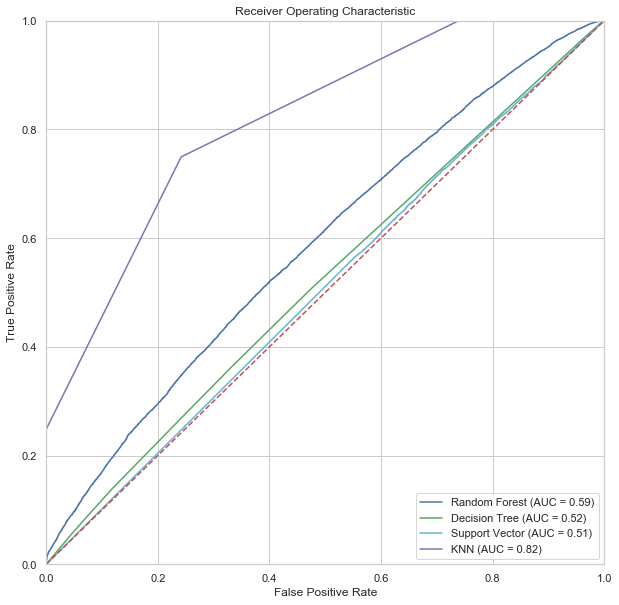

In [46]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rfc, tpr_rfc, 'b', label = 'Random Forest (AUC = %0.2f)' % rfc_roc_auc)
plt.plot(fpr_dtc, tpr_dtc, 'g', label = 'Decision Tree (AUC = %0.2f)' % dtc_roc_auc)
plt.plot(fpr_svc, tpr_svc, 'c', label = 'Support Vector (AUC = %0.2f)' % svc_roc_auc)
plt.plot(fpr_knn, tpr_knn, 'm', label = 'KNN (AUC = %0.2f)' % knn_roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

From the table, we can see that KNN has the highest accuracy & f1 score.  When we look at the ROC curves, we can see that it also has the highest AUC.  Since KNN classifiers have a risk of overfitting, the KNN cross validation scores will have a lot more weight when determining if the model is viable.  We can see that the KNN classifer has the lowest cross validation scores.  It may not be a good choice.

However, random forest has the best cross validation scores, second highest accuracy, second highest F1 score, & second highest ROC AUC.  Also, we can see that there isn't a major difference between the average cv & accuracy.  This suggests that the model would be much less susceptible to overfitting.

Therefore, it would make sense to choose the random forest classifier as the best model.

# Optimize Best Model with Gridsearch

Let's fine-tune the random forest classifier to get the final model.  For our first iteration, we will try to play with max depth, n_estimators, & max_features.

In [47]:
# first iteration
params = {
    'max_depth': [2, 4, 8], 
    'n_estimators': [200, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True], 
         }

In [48]:
# check which combination is best
rfc2 = RandomForestClassifier(n_jobs=-1)
grid = GridSearchCV(rfc2, params, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

grid.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Based on this iteration, we can see that max_depth could be higher.  Let's check if making the max_depth higher will give a better combination.  Also for n_estimators, let's narrow the range to see if the sweet spot is inbetween 200-500 or 500-1000.  Let's lock in max_features as sqrt.  We will also start toggling min_samples_split in the gridCV.

In [49]:
# second iteration
params = {
    'max_depth': [6, 8, 10], 
    'n_estimators': [350, 500, 625],
    'max_features': ['sqrt'], 
    'min_samples_split': [2, 20, 100], 
    'bootstrap': [True], 
         }

In [50]:
rfc2 = RandomForestClassifier(n_jobs=-1)
grid = GridSearchCV(rfc2, params, n_jobs=-1, cv=3)
grid.fit(X_train, y_train)

grid.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Let's quit here as any more optimizing will have diminishing returns.

# Testing Final Model

Let's put the final parameters in.

In [51]:
rfc3 = grid.best_estimator_
rfc3.fit(X_train, y_train)
rfc3_results = model_metrics(rfc3, X_test, y_test)

In [52]:
# print metrics
format_metrics(rfc3_results)

Cross Validation Scores
[0.5019880715705766, 0.5417495029821073, 0.49801192842942343, 0.5029821073558648, 0.5089463220675944, 0.5099403578528827, 0.5149105367793241, 0.525844930417495, 0.5044776119402985, 0.5114427860696518]

Average CV = 0.5120294155465218

Classification Report
              precision    recall  f1-score   support

           1       0.53      0.65      0.59      5160
           2       0.52      0.40      0.46      4898

    accuracy                           0.53     10058
   macro avg       0.53      0.53      0.52     10058
weighted avg       0.53      0.53      0.52     10058

Confusion Matrix
True Positives = 1974
True Negatives= 3363
True Negatives = 1797
True Negatives = 2924


This final model has a slightly higher accuracy & cross-validation.

# Conclusion: 

We concluded that champion choice, ban list, & summoner spells does partially account for player wins. Even without taking player skill into account, we can still produce a model that's better than a coin flip. 

That being said, there are some ways we can improve the model if we can include player skill.  Naturally, if we had player metrics (i.e, player rank, number of lifetime wins/loses, win/lose streaks), we could have a much more accurate model.